In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../')
from dependencies import utils

In [13]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [14]:
from sklearn.preprocessing import StandardScaler


def get_all():
    large = tracks['set', 'subset'] <= 'large'

    genre1 = tracks['track', 'genre_top'] == 'Rock'
    genre2 = tracks['track', 'genre_top'] == 'Pop'
    genre3 = tracks['track', 'genre_top'] == 'Electronic'
    genre4 = tracks['track', 'genre_top'] == 'Instrumental'
    genre5 = tracks['track', 'genre_top'] == 'Hip-Hop'

    train = tracks['set', 'split'] == 'training'
    val = tracks['set', 'split'] == 'validation'
    test = tracks['set', 'split'] == 'test'

    y_train = tracks.loc[large & train & (
        genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
    y_test = tracks.loc[large & test & (
        genre1 | genre2 | genre3 | genre4 | genre5), ('track', 'genre_top')]
    X_train = features.loc[large & train & (
        genre1 | genre2 | genre3 | genre4 | genre5)]
    X_test = features.loc[large & test & (
        genre1 | genre2 | genre3 | genre4 | genre5)]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_all()
X_train.shape


(25360, 518)

In [15]:
from sklearn.decomposition import PCA
def pca_preprocess(X_train, X_test):
	X_train = StandardScaler().fit_transform(X_train)
	X_test = StandardScaler().fit_transform(X_test)
	pca = PCA(n_components=10)
	pca.fit(X_train)
	print("Explained Variance", pca.explained_variance_ratio_[:10])
	print("Singular Values", pca.singular_values_[:10])
	X_train = pca.fit_transform(X_train)
	X_test = pca.transform(X_test)
	return X_train, X_test

In [16]:
X_train, X_test = pca_preprocess(X_train, X_test)
X_train.shape

c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


Explained Variance [0.1065275  0.0730906  0.04381973 0.03260251 0.03014247 0.02713127
 0.02623769 0.02348421 0.02298346 0.01997074]
Singular Values [1182.96084397  979.87408384  758.70744168  654.43275092  629.25821704
  597.00029525  587.08674558  555.42768497  549.47408165  512.19645592]


(25360, 10)

In [17]:
y_test.unique()

['Rock', 'Electronic', 'Instrumental', 'Pop', 'Hip-Hop']
Categories (5, object): ['Rock', 'Electronic', 'Instrumental', 'Pop', 'Hip-Hop']

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [10, 100, 200, 300, 500, 1000],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                         return_train_score=False,
                         n_iter=6)
knn.fit(X_train, y_train)

knn.best_params_


{'weights': 'distance', 'n_neighbors': 100, 'algorithm': 'ball_tree'}

In [19]:
pd.DataFrame(knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,param_n_neighbors,param_algorithm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012172,0.002126,1.729257,0.051486,distance,300,brute,"{'weights': 'distance', 'n_neighbors': 300, 'a...",0.610804,0.633675,0.627563,0.654574,0.641167,0.633557,0.014514,3
1,0.027806,0.001452,1.471299,0.012314,uniform,200,auto,"{'weights': 'uniform', 'n_neighbors': 200, 'al...",0.613170,0.634069,0.633478,0.655166,0.640970,0.635371,0.013574,2
2,0.028350,0.001374,2.995864,0.061070,distance,1000,auto,"{'weights': 'distance', 'n_neighbors': 1000, '...",0.595426,0.615931,0.607453,0.634069,0.617902,0.614156,0.012724,5
3,0.011616,0.000851,1.993154,0.030472,uniform,1000,brute,"{'weights': 'uniform', 'n_neighbors': 1000, 'a...",0.593651,0.611790,0.604692,0.624409,0.614945,0.609897,0.010302,6
4,0.028013,0.001096,2.046554,0.020190,uniform,500,kd_tree,"{'weights': 'uniform', 'n_neighbors': 500, 'al...",0.605087,0.627760,0.618494,0.640379,0.629929,0.624330,0.011875,4
5,0.025443,0.001638,1.527482,0.005978,distance,100,ball_tree,"{'weights': 'distance', 'n_neighbors': 100, 'a...",0.619874,0.638998,0.640773,0.668178,0.646688,0.642902,0.015513,1


              precision    recall  f1-score   support

  Electronic       0.59      0.69      0.63       839
     Hip-Hop       0.56      0.37      0.44       323
Instrumental       0.72      0.24      0.36       309
         Pop       0.00      0.00      0.00       204
        Rock       0.73      0.91      0.81      1464

    accuracy                           0.67      3139
   macro avg       0.52      0.44      0.45      3139
weighted avg       0.63      0.67      0.63      3139



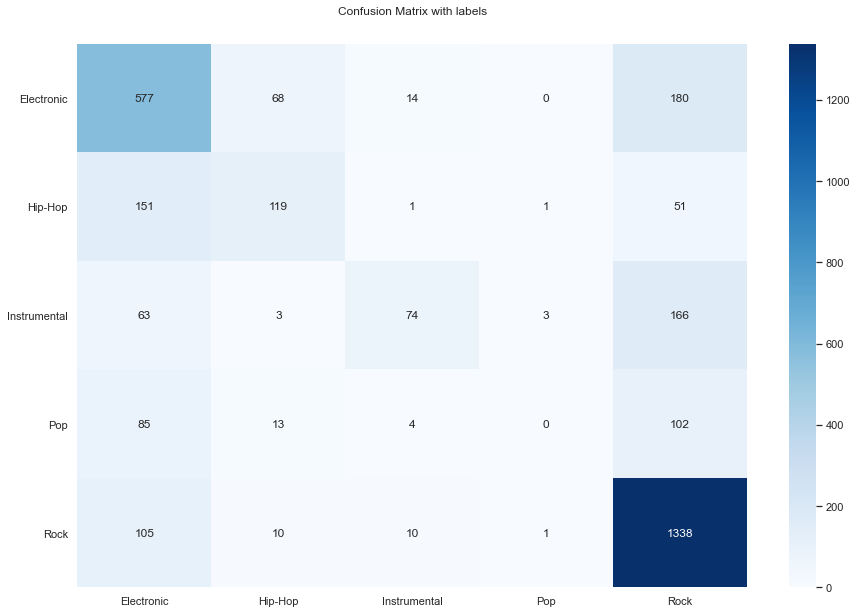

In [20]:
neigh = KNeighborsClassifier(n_neighbors=100, weights="distance", algorithm="ball_tree")
y_pred = neigh.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(neigh.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(neigh.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

plt.show()

In [21]:
from sklearn.manifold import TSNE

def tsne_preprocess(X_train, X_test):
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    tsne = TSNE(n_components=2)
    tsne.fit(X_train)
    X_train = tsne.fit_transform(X_train)
    X_test = tsne.fit_transform(X_test)
    return X_train, X_test

X_train.shape


(25360, 10)

In [22]:
X_train, X_test, y_train, y_test = get_all()
X_train, X_test = tsne_preprocess(X_train, X_test)

c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\groot\anaconda3\lib\site-packages\sklea

              precision    recall  f1-score   support

  Electronic       0.28      0.33      0.30       839
     Hip-Hop       0.08      0.06      0.07       323
Instrumental       0.09      0.01      0.02       309
         Pop       0.09      0.00      0.01       204
        Rock       0.58      0.75      0.66      1464

    accuracy                           0.44      3139
   macro avg       0.23      0.23      0.21      3139
weighted avg       0.37      0.44      0.40      3139



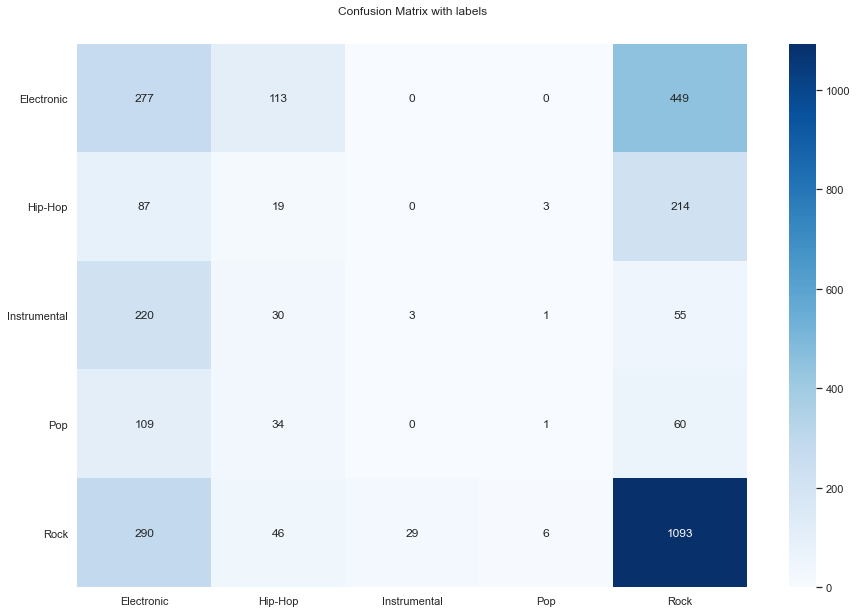

In [23]:
neigh = KNeighborsClassifier(n_neighbors=100, weights="distance", algorithm="ball_tree")
y_pred = neigh.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(neigh.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(neigh.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

plt.show()